# Jul 6th, 2022 (Fig-3 OCs; K=3)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.mouse import Mice
from model.configuration import Config
from analysis.similarity import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
fig_dir = 'Fig3_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512/Fig3_OCs

## Prepare (512)

In [3]:
mice = Mice(nn)
task = 'rest'

num_k, p = 3, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

bt = BootStrap(**props_ca)
bt_bo = BootStrap(**props_bo)

mice.setup_func_data(task, band_ca=(0.01, 0.5))
bt_cas = BootStrap(**props_ca)

mice.setup_func_data(task, band_ca=0.5)
bt_caf = BootStrap(**props_ca)

bt_dict = {
    BOLD: bt_bo,
    CAS: bt_cas,
    CAF: bt_caf,
}

## Save dir

In [4]:
save_dir = pjoin(fig_dir, f"K{num_k}")
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512/Fig3_OCs/K3

## OCs

In [5]:
kws_show = {
    'vmin': 0.2,
    'vmax': 1.0,
    'mask_thresh': 1 / 7,
    'add_disjoint': True,
    'add_title': True,
    'figsize_x': 2.5,
    'dpi': 150,
}

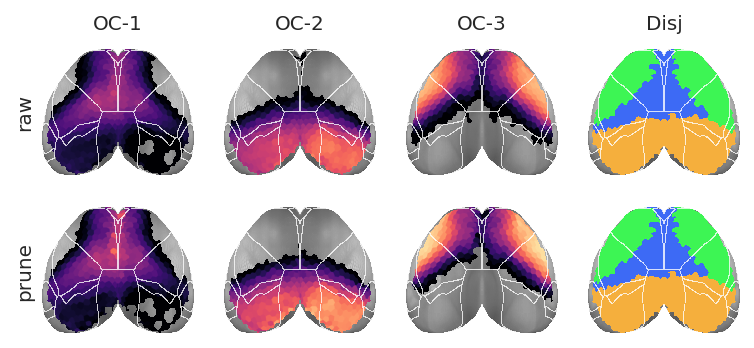

In [6]:
_ = bt.show(
    data={
        'raw': avg(bt_bo.run_pi),
        'prune': avg(bt_bo.pi_prune)},
    **kws_show,
)

## Similarity

### Get results

In [7]:
%%time

results = similiarity_results(bt_dict, None, int(1e5))
list(results)

CPU times: user 5min 25s, sys: 3.17 s, total: 5min 28s
Wall time: 5min 31s


[
    'pi_sorted',
    'gmaps',
    'sim',
    'sim_b',
    'sim_overall',
    'sim_overall_b',
    'tests',
    'good_runs',
    'data4perm'
]

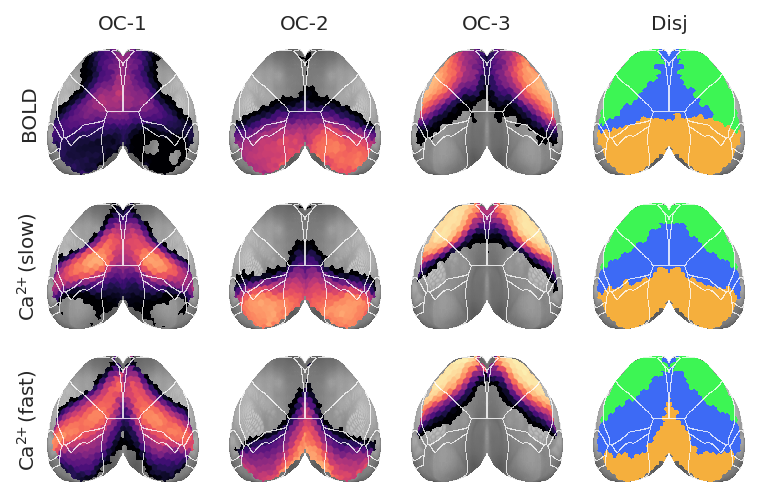

In [8]:
_ = bt.show(
    data=results['pi_sorted'],
    **kws_show,
)

### Plot heatmap

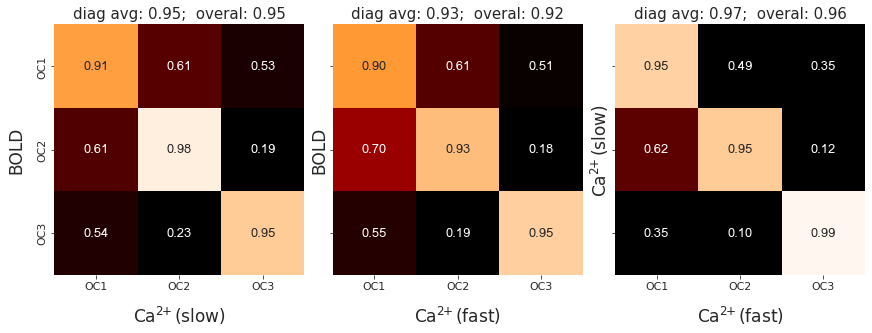

In [9]:
from figures.fig_ocs import similiarity_heatmap as go
_ = go(results['sim'], results['sim_overall'], True, True)
fig, _ = go(results['sim'], results['sim_overall'], False, False)

fig.savefig(pjoin(save_dir, 'sim_hm.pdf'), **kws_fig)
fig.savefig(pjoin(save_dir, 'sim_hm.png'), **kws_fig)

### Plot line

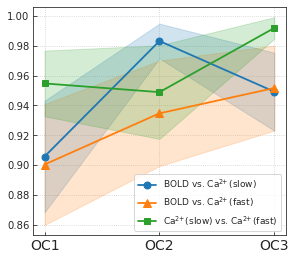

In [10]:
from figures.fig_ocs import similiarity_line as go
fig, _ = go(results['sim'], results['sim_b'], True, figsize=(4, 3.5), legend_fontsize=9, legend_loc='lower right')

fig.savefig(pjoin(save_dir, 'sim_ln.pdf'), **kws_fig)
fig.savefig(pjoin(save_dir, 'sim_ln.png'), **kws_fig)

### Look at boot stuff

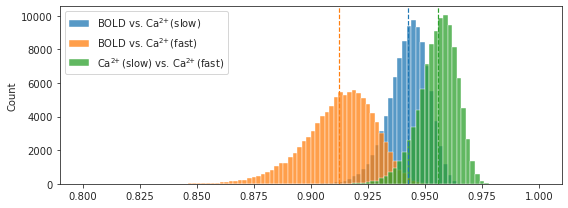

In [11]:
fig, ax = create_figure(1, 1, (8, 3))
for i, ((lbl_1, lbl_2), x) in enumerate(results['sim_overall_b'].items()):
    sns.histplot(
        data=x,
        bins=np.linspace(0.8, 1, 101),
        label=f"{lbl_1} vs. {lbl_2}",
        color=f"C{i}",
        ax=ax
    )
    ax.axvline(x.mean(), color=f"C{i}", ls='--', lw=1.2)
ax.legend()
plt.show()

In [12]:
for k, v in results['sim_overall_b'].items():
    se = np.nanstd(v, 0, ddof=1)
    print(k, se, np.round(se * get_tval(), 3))

('BOLD', 'Ca$^{2\\!\\!+}$(slow)')
0.008659868311311266 0.02

('BOLD', 'Ca$^{2\\!\\!+}$(fast)')
0.01535069152411621 0.035

('Ca$^{2\\!\\!+}$(slow)', 'Ca$^{2\\!\\!+}$(fast)')
0.008401732341342658 0.019

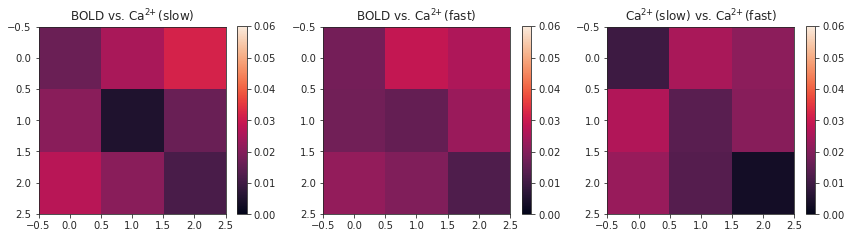

In [13]:
fig, axes = create_figure(1, 3, (12, 3.2))
for i, (k, v) in enumerate(results['sim_b'].items()):
    se = np.nanstd(v, 0, ddof=1)
    
    ax = axes[i]
    im = ax.imshow(se, cmap='rocket', vmin=0, vmax=0.06)
    ax.set_title(f"{k[0]} vs. {k[1]}")
    plt.colorbar(im, ax=ax)
plt.show()

### Perm test

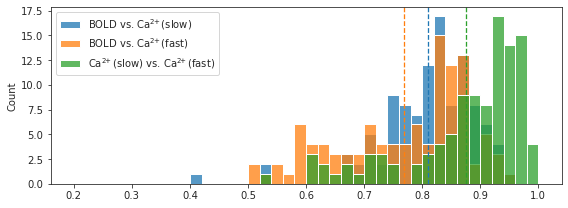

In [14]:
fig, ax = create_figure(1, 1, (8, 3))
for i, ((lbl_1, lbl_2), x) in enumerate(results['data4perm'].items()):
    sns.histplot(
        data=x,
        bins=np.linspace(0.2, 1, 41),
        label=f"{lbl_1} vs. {lbl_2}",
        color=f"C{i}",
        ax=ax,
    )
    ax.axvline(x.mean(), color=f"C{i}", ls='--', lw=1.3)
ax.legend()
plt.show()

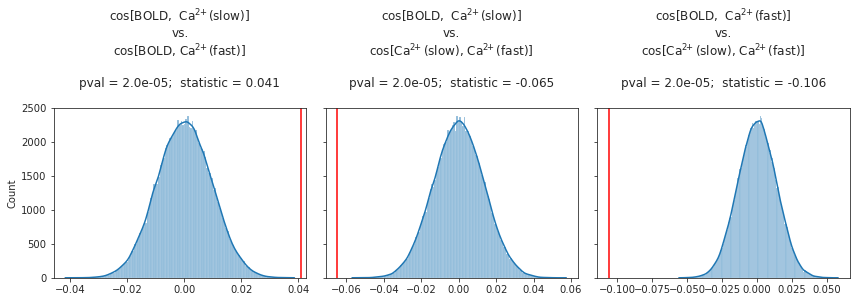

In [15]:
fig, axes = create_figure(1, 3, (12, 4.3), sharey='all')

for i, ((cond_1, cond_2), test) in enumerate(results['tests'].items()):
    ax = axes[i]   
    sns.histplot(test.null_distribution, kde=True, ax=ax)
    ax.axvline(test.statistic, color='r')
    title = f"cos[{cond_1[0]},  {cond_1[1]}]\nvs.\ncos[{cond_2[0]}, {cond_2[1]}]\n\n"
    title += f"pval = {test.pvalue:1.1e};  statistic = {test.statistic:.3f}\n"
    ax.set_title(title)
plt.show()

In [16]:
multipletests([4e-6, 2e-6, 2e-6], alpha=0.001, method='fdr_bh')[0]

array([ True,  True,  True])

## Make column plots

In [17]:
from figures.fighelper import ctx2ax

save_dir = pjoin(save_dir, 'OCs')
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512/Fig3_OCs/K3/OCs

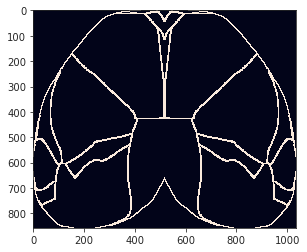

In [18]:
contour = bt.get_contour(0.2, True)
plt.imshow(contour);

In [19]:
kwargs = {
    'base': bt,
    'vmin': 0.2,
    'vmax': 1.0,
    'cbar': False,
    'cmap': 'magma',
    'contour': contour,
    'contour_alpha': 0.8,
    'interp': 'antialiased',
}
mask_thres = 1 / 7

for i in range(num_k):
    fig, axes = create_figure(
        nrows=3,
        ncols=1,
        figsize=(3, 7),
        sharex='all',
        sharey='all',
        tight_layout=False,
        constrained_layout=True,
    )
    for j, (mode, pi) in enumerate(results['pi_sorted'].items()):
        x = pi[i].copy()
        x[x < mask_thres] = np.nan
        ctx2ax(x=x, ax=axes[j], **kwargs)
    remove_ticks(axes)
    fig.savefig(pjoin(save_dir, f'OC-{i+1}.png'), **kws_fig)
    plt.close()
    
    
kwargs_disj = kwargs.copy()
kwargs_disj['vmin'] = 1
kwargs_disj['vmax'] = num_k
kwargs_disj['interp'] = 'none'
kwargs_disj['cmap'] = get_cluster_cmap(range(num_k))

fig, axes = create_figure(
    nrows=3,
    ncols=1,
    figsize=(3, 7),
    sharex='all',
    sharey='all',
    tight_layout=False,
    constrained_layout=True,
)
for j, (mode, pi) in enumerate(results['pi_sorted'].items()):
    x = np.argmax(pi, 0) + 1.0
    x[np.isnan(pi).sum(0) > 0] = np.nan
    ctx2ax(x=x, ax=axes[j], **kwargs_disj)
remove_ticks(axes)
fig.savefig(pjoin(save_dir, f'disj.png'), **kws_fig)
plt.close()